#### Install dependencies

In [ ]:
%pip install -U openmim
!mim install mmcv-full

# install mmpose dependencies
%pip install -v -r requirements.txt

%pip install mmdet
%pip install mmpose
# install mmpose in develop mode
%pip install -v -e .
%pip install tables
%run setup_env.py

In [10]:
test_pose_estimator('work_dirs/hrnet_w_acino_256x256',
                    'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/hrnet_w32_acino_256x256.py',
                    False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
=> num_images: 1528
=> load 1510 samples
load checkpoint from local path: work_dirs/hrnet_w32_acino_256x256/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1510/1510, 108.9 task/s, elapsed: 14s, ETA:     0sLoading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.792
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.907
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.640
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.828
 Average Recall 

### 2D

#### Extract all AcinoSet 2D Labelled data: COCO format

In [ ]:
# NB: unzip "labelled_data.zip" to "/notebooks/data/acino/labelled" first

acino='/notebooks/data/acino'

img_ids=[os.path.splitext(img)[0] for img in os.listdir(acino+'/../ap10k/data/')]
img_ids.remove('.ipynb_checkpoints')
img_ids=[int(i) for i in img_ids]
img_no=max(img_ids)+1

base=pd.read_csv('base.csv')

for dir in os.listdir(acino+'/labelled'): #JamesFlick1 JamesFlick2 etc.
    print(dir)
    if os.path.isdir(acino+'/labelled/'+dir):
        
        df=pd.read_csv('labelled/'+dir+'/'+"CollectedData_UCT.csv")

        df.iloc[0,1:]=df.iloc[0,1:].astype(str) +'_'+ df.iloc[1,1:].astype(str)
        df.columns=df.iloc[0] # Make keypoint labels column headers
        df=df.iloc[2:,:]
        
        #Extract COCO keypoints (AP10K):
        #df=df.reindex(columns=(['bodyparts','l_eye_x','l_eye_y','r_eye_x','r_eye_y','nose_x','nose_y','neck_base_x','neck_base_y','tail_base_x','tail_base_y','l_shoulder_x','l_shoulder_y','l_front_knee_x','l_front_knee_y','l_front_paw_x','l_front_paw_y','r_shoulder_x','r_shoulder_y','r_front_knee_x','r_front_knee_y','r_front_paw_x','r_front_paw_y','l_hip_x','l_hip_y','l_back_knee_x','l_back_knee_y','l_back_paw_x','l_back_paw_y','r_hip_x','r_hip_y','r_back_knee_x','r_back_knee_y','r_back_paw_x','r_back_paw_y','tail2_x','tail2_y']))
        
        #Extract COCO keypoints (All Acino Keypoints):
        df=df.reindex(columns=(['bodyparts','l_eye_x','l_eye_y','r_eye_x','r_eye_y','nose_x','nose_y','neck_base_x','neck_base_y','tail_base_x','tail_base_y','l_shoulder_x','l_shoulder_y','l_front_knee_x','l_front_knee_y','l_front_paw_x','l_front_paw_y','r_shoulder_x','r_shoulder_y','r_front_knee_x','r_front_knee_y','r_front_paw_x','r_front_paw_y','l_hip_x','l_hip_y','l_back_knee_x','l_back_knee_y','l_back_paw_x','l_back_paw_y','r_hip_x','r_hip_y','r_back_knee_x','r_back_knee_y','r_back_paw_x','r_back_paw_y','tail2_x','tail2_y','tail1_x','tail1_y','r_front_ankle_x','r_front_ankle_y','l_front_ankle_x','l_front_ankle_y','r_back_ankle_x','r_back_ankle_y','l_back_ankle_x','l_back_ankle_y','spine_x','spine_y']))
        
        for i in range(0,len(df)): # Iterate over rows
            orig=df.iloc[i,0].split('/')[2]
            df.iloc[i,0]='as_'+str(img_no)+'.jpg'
            
            im=Image.open('data/acino/labelled/'+dir+'/'+orig)
            img_name='as_'+str(img_no)
            im.save('data/acino/data/'+img_name+'.jpg')
            
            #os.remove('labelled1/'+dir+'/'+orig)
            
            
            img_no+=1
        base=pd.concat([base,df[0:]],ignore_index=True)
               
base.to_csv("data/acino/annotations.csv",index=False)

In [ ]:
df = pd.read_csv('data/acino/annotations.csv')

if os.path.exists("data/acino/annotations/acino_all.json"):
    os.remove("data/acino/annotations/acino_all.json")
    
shutil.copyfile('data/acino/annotations/anns_empty_acino.json','data/acino/annotations/acino_all.json')

with open('data/acino/annotations/acino_all.json','r+') as f: # Save all annotation instances in one .json file
    anns_data=json.load(f)
    
    for i in range(0,len(df)):# Iterate over each image

        #Add image instance
        img_name=df.iloc[i,0]
        img_id=int(img_name[3:].split('.')[0])
        img=cv2.imread('data/acino/data/'+img_name)
        height = img.shape[0]
        width = img.shape[1]
        img_inst=dict(width=width,height=height,file_name=img_name,background=1,id=img_id)
        
        #Add annotation instance
        ann_id=img_id
        kp=[]
        num_kp=0

        # Initial bbox:
        x_min=width-1
        x_max=1
        y_min=height-1
        y_max=1

        for j in range(1,len(df.columns),2): # -12 for AP10k format
            if pd.isnull(df.iloc[i,j]): #NaN values
                kp.append(0)
                kp.append(0)
                kp.append(0)
                
            else:
                x=int(round(pd.to_numeric(df.iloc[i,j])))
                y=int(round(pd.to_numeric(df.iloc[i,j+1])))
                
                #Add annotations
                kp.append(x)
                kp.append(y)
                kp.append(2)
                num_kp+=1

                #Bbox
                if x<x_min:
                    x_min=x
                if x>x_max:
                    x_max=x
                if y>y_max:
                    y_max=y
                if y<y_min:
                    y_min=y
                    
        # Pad bbox with extra pixels:
        x_min=x_min-15
        y_min=y_min-15
        
        # BBox w, h
        w=max(1,(x_max-x_min))+30
        h=max(1,(y_max-y_min))+30
        a=w*h # Bbox area
        
        #Padded bounding box:
        bbox=[x_min,y_min,w,h] # xywh format NB! y_min==top left corner
        
        # Uncomment for AP10k format:
        
#         if kp[-1]==2: # If tip of tail != NaN
#             num_kp-=1 
            
#         del kp[-3:] # Remove tail_x, tail_y, visible
        
        
        ann_inst=dict(image_id=img_id,iscrowd=0,category_id=1,num_keypoints=num_kp,keypoints=kp,bbox=bbox,id=ann_id,area=a)
        anns_data['images'].append(img_inst)
        anns_data['annotations'].append(ann_inst)
    f.seek(0)
    json.dump(anns_data,f,indent=4)
f.close()

#### Split into train-val-test sets

In [ ]:
%pip install echo1-coco-split

!coco-split --annotations_file data/acino/annotations/acino_all.json --valid_ratio 0.1 --test_ratio 0.2 --train_name data/acino/annotations/acino_train.json --valid_name data/acino/annotations/acino_val.json --test_name data/acino/annotations/acino_test.json --has_annotations

Text(0.5, 1.0, "RetinaNet and Faster-RCNN's IoU scores on AcinoSet test-set")

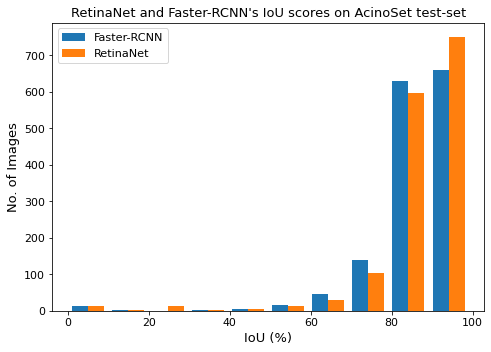

In [70]:
iou1=[i*100 for i in ious1]
iou2=[i*100 for i in ious2]

import matplotlib.pyplot as plt
fig = plt.figure(figsize =(6, 4))
ax=fig.add_axes([0, 0, 1, 1])
bp=ax.hist([iou1,iou2],label=['Faster-RCNN','RetinaNet'])
ax.legend(fontsize=11.3
         )
ax.tick_params(axis='both', which='major', labelsize=11)
plt.xlabel("IoU (%)",fontsize=13)
plt.ylabel("No. of Images",fontsize =13)
plt.title("The distribution of RetinaNet and Faster-RCNN's IoU scores on AcinoSet test-set",fontsize=13)

#### Train, test and demo 2D pose estimator

##### Train model from cfg: 

In [ ]:
cfg ='configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/res101_acino_256x256.py'
train_2D_cfg(cfg,True)

2022-10-31 20:27:03,175 - mmpose - INFO - Distributed training: False
2022-10-31 20:27:03,176 - mmpose - INFO - Set random seed to 0, deterministic: False


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
=> num_images: 5346
=> load 5289 samples
load checkpoint from torchvision path: torchvision://resnet101


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-10-31 20:27:06,655 - mmpose - INFO - Start running, host: root@nxwe1490cr, work_dir: /notebooks/work_dirs/res101_acino_256x256_pretr
2022-10-31 20:27:06,656 - mmpose - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
 ---

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
=> num_images: 764
=> load 757 samples


2022-10-31 20:27:12,799 - mmpose - INFO - Epoch [1][5/166]	lr: 7.643e-06, eta: 3:57:34, time: 1.227, data_time: 0.861, memory: 6467, heatmap_loss: 0.0017, acc_pose: 0.0346, loss: 0.0017
2022-10-31 20:27:14,817 - mmpose - INFO - Epoch [1][10/166]	lr: 1.613e-05, eta: 2:37:46, time: 0.404, data_time: 0.094, memory: 6467, heatmap_loss: 0.0017, acc_pose: 0.0442, loss: 0.0017
2022-10-31 20:27:16,898 - mmpose - INFO - Epoch [1][15/166]	lr: 2.463e-05, eta: 2:11:58, time: 0.416, data_time: 0.107, memory: 6467, heatmap_loss: 0.0015, acc_pose: 0.0441, loss: 0.0015
2022-10-31 20:27:18,918 - mmpose - INFO - Epoch [1][20/166]	lr: 3.312e-05, eta: 1:58:27, time: 0.404, data_time: 0.093, memory: 6467, heatmap_loss: 0.0015, acc_pose: 0.0670, loss: 0.0015
2022-10-31 20:27:21,294 - mmpose - INFO - Epoch [1][25/166]	lr: 4.161e-05, eta: 1:53:05, time: 0.475, data_time: 0.162, memory: 6467, heatmap_loss: 0.0016, acc_pose: 0.1069, loss: 0.0016
2022-10-31 20:27:23,268 - mmpose - INFO - Epoch [1][30/166]	lr: 5.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 757/757, 67.8 task/s, elapsed: 11s, ETA:     0sLoading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.546
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.967
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.561
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.399
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.565
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.603
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.976
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.670
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2022-10-31 20:32:28,880 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_5.pth.
2022-10-31 20:32:28,884 - mmpose - INFO - Best AP is 0.5464 at 5 epoch.
2022-10-31 20:32:28,885 - mmpose - INFO - Epoch(val) [5][24]	AP: 0.5464, AP .5: 0.9672, AP .75: 0.5608, AP (M): 0.3990, AP (L): 0.5647, AR: 0.6032, AR .5: 0.9762, AR .75: 0.6697, AR (M): 0.4967, AR (L): 0.6177
2022-10-31 20:32:34,143 - mmpose - INFO - Epoch [6][5/166]	lr: 8.500e-04, eta: 1:07:24, time: 1.050, data_time: 0.726, memory: 6467, heatmap_loss: 0.0007, acc_pose: 0.7489, loss: 0.0007
2022-10-31 20:32:35,774 - mmpose - INFO - Epoch [6][10/166]	lr: 8.500e-04, eta: 1:07:19, time: 0.326, data_time: 0.010, memory: 6467, heatmap_loss: 0.0008, acc_pose: 0.7142, loss: 0.0008
2022-10-31 20:32:37,453 - mmpose - INFO - Epoch [6][15/166]	lr: 8.500e-04, eta: 1:07:15, time: 0.336, data_time: 0.021, memory: 6467, heatmap_loss: 0.0008, acc_pose: 0.7426, loss: 0.0008
2022-10-31 20:32:39,325 - mmpose - INFO - Epoch [6][20/166]	lr:

In [ ]:
cfg ='configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/res101_acino_256x256.py'
train_2D_cfg(cfg,False)

In [2]:
# Config file:
cfg = 'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/hrnet_w32_acino_256x256.py'
train_2D_cfg(cfg,True)

/notebooks/mmpose/utils/setup_env.py:32: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
/notebooks/mmpose/utils/setup_env.py:42: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
2022-10-29 11:34:18,602 - mmpose - INFO - Distributed training: False
2022-10-29 11:34:18,604 - mmpose - INFO - Set random seed to 0, deterministic: False


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
=> num_images: 5346
=> load 5289 samples
load checkpoint from http path: https://download.openmmlab.com/mmpose/pretrain_models/hrnet_w32-36af842e.pth


Downloading: "https://download.openmmlab.com/mmpose/pretrain_models/hrnet_w32-36af842e.pth" to /root/.cache/torch/hub/checkpoints/hrnet_w32-36af842e.pth


  0%|          | 0.00/126M [00:00<?, ?B/s]

2022-10-29 11:34:37,638 - mmpose - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.0.0.0.conv1.weight, head.0.0.0.bn1.weight, head.0.0.0.bn1.bias, head.0.0.0.bn1.running_mean, head.0.0.0.bn1.running_var, head.0.0.0.bn1.num_batches_tracked, head.0.0.0.conv2.weight, head.0.0.0.bn2.weight, head.0.0.0.bn2.bias, head.0.0.0.bn2.running_mean, head.0.0.0.bn2.running_var, head.0.0.0.bn2.num_batches_tracked, head.0.0.0.conv3.weight, head.0.0.0.bn3.weight, head.0.0.0.bn3.bias, head.0.0.0.bn3.running_mean, head.0.0.0.bn3.running_var, head.0.0.0.bn3.num_batches_tracked, head.0.0.0.downsample.0.weight, head.0.0.0.downsample.1.weight, head.0.0.0.downsample.1.bias, head.0.0.0.downsample.1.running_mean, head.0.0.0.downsample.1.running_var, head.0.0.0.downsample.1.num_batches_tracked, head.0.1.0.conv1.weight, head.0.1.0.bn1.weight, head.0.1.0.bn1.bias, head.0.1.0.bn1.running_mean, head.0.1.0.bn1.running_var, head.0.1.0.bn1.num_batches_tracked, he

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
=> num_images: 764
=> load 757 samples


2022-10-29 11:34:54,035 - mmpose - INFO - Epoch [1][5/83]	lr: 7.643e-06, eta: 4:38:44, time: 2.881, data_time: 1.179, memory: 12828, heatmap_loss: 0.0015, acc_pose: 0.0234, loss: 0.0015
2022-10-29 11:34:59,192 - mmpose - INFO - Epoch [1][10/83]	lr: 1.613e-05, eta: 3:09:06, time: 1.031, data_time: 0.001, memory: 12828, heatmap_loss: 0.0016, acc_pose: 0.0281, loss: 0.0016
2022-10-29 11:35:04,267 - mmpose - INFO - Epoch [1][15/83]	lr: 2.463e-05, eta: 2:38:38, time: 1.015, data_time: 0.001, memory: 12828, heatmap_loss: 0.0016, acc_pose: 0.0378, loss: 0.0016
2022-10-29 11:35:09,278 - mmpose - INFO - Epoch [1][20/83]	lr: 3.312e-05, eta: 2:23:02, time: 1.002, data_time: 0.001, memory: 12828, heatmap_loss: 0.0016, acc_pose: 0.0489, loss: 0.0016
2022-10-29 11:35:14,262 - mmpose - INFO - Epoch [1][25/83]	lr: 4.161e-05, eta: 2:13:33, time: 0.997, data_time: 0.001, memory: 12828, heatmap_loss: 0.0016, acc_pose: 0.0752, loss: 0.0016
2022-10-29 11:35:19,292 - mmpose - INFO - Epoch [1][30/83]	lr: 5.0

[>>>>>>                        ] 159/757, 43.9 task/s, elapsed: 4s, ETA:    14s

2022-10-29 12:03:38,307 - mmpose - INFO - Epoch [20][5/83]	lr: 8.500e-04, eta: 1:13:34, time: 2.106, data_time: 1.097, memory: 12828, heatmap_loss: 0.0005, acc_pose: 0.8369, loss: 0.0005
2022-10-29 12:03:43,336 - mmpose - INFO - Epoch [20][10/83]	lr: 8.500e-04, eta: 1:13:28, time: 1.006, data_time: 0.003, memory: 12828, heatmap_loss: 0.0005, acc_pose: 0.8527, loss: 0.0005
2022-10-29 12:03:48,363 - mmpose - INFO - Epoch [20][15/83]	lr: 8.500e-04, eta: 1:13:23, time: 1.005, data_time: 0.001, memory: 12828, heatmap_loss: 0.0005, acc_pose: 0.8681, loss: 0.0005
2022-10-29 12:03:53,417 - mmpose - INFO - Epoch [20][20/83]	lr: 8.500e-04, eta: 1:13:17, time: 1.011, data_time: 0.001, memory: 12828, heatmap_loss: 0.0005, acc_pose: 0.8619, loss: 0.0005
2022-10-29 12:03:58,457 - mmpose - INFO - Epoch [20][25/83]	lr: 8.500e-04, eta: 1:13:11, time: 1.008, data_time: 0.002, memory: 12828, heatmap_loss: 0.0005, acc_pose: 0.8428, loss: 0.0005
2022-10-29 12:04:03,503 - mmpose - INFO - Epoch [20][30/83]	l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 757/757, 86.7 task/s, elapsed: 9s, ETA:     0sLoading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.21s).
Accumulating evaluation results...


2022-10-29 12:05:07,065 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/hrnet_w32_acino_256x256_pretr/best_AP_epoch_15.pth was removed


DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.751
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.979
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.876
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.599
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.769
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.791
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.987
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.906
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.657
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.810


2022-10-29 12:05:08,366 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_20.pth.
2022-10-29 12:05:08,367 - mmpose - INFO - Best AP is 0.7512 at 20 epoch.
2022-10-29 12:05:08,368 - mmpose - INFO - Epoch(val) [20][24]	AP: 0.7512, AP .5: 0.9787, AP .75: 0.8764, AP (M): 0.5990, AP (L): 0.7693, AR: 0.7914, AR .5: 0.9868, AR .75: 0.9062, AR (M): 0.6571, AR (L): 0.8098
2022-10-29 12:05:18,871 - mmpose - INFO - Epoch [21][5/83]	lr: 8.500e-04, eta: 1:12:06, time: 2.099, data_time: 1.093, memory: 12828, heatmap_loss: 0.0005, acc_pose: 0.8784, loss: 0.0005
2022-10-29 12:05:23,922 - mmpose - INFO - Epoch [21][10/83]	lr: 8.500e-04, eta: 1:12:00, time: 1.010, data_time: 0.002, memory: 12828, heatmap_loss: 0.0005, acc_pose: 0.8780, loss: 0.0005
2022-10-29 12:05:28,959 - mmpose - INFO - Epoch [21][15/83]	lr: 8.500e-04, eta: 1:11:55, time: 1.007, data_time: 0.001, memory: 12828, heatmap_loss: 0.0005, acc_pose: 0.8468, loss: 0.0005
2022-10-29 12:05:33,987 - mmpose - INFO - Epoch [21][20/8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 757/757, 85.1 task/s, elapsed: 9s, ETA:     0sLoading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*


2022-10-29 12:12:42,046 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/hrnet_w32_acino_256x256_pretr/best_AP_epoch_20.pth was removed


DONE (t=0.19s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.752
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.980
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.863
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.596
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.772
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.791
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.988
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.892
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.810


2022-10-29 12:12:43,125 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_25.pth.
2022-10-29 12:12:43,126 - mmpose - INFO - Best AP is 0.7521 at 25 epoch.
2022-10-29 12:12:43,127 - mmpose - INFO - Epoch(val) [25][24]	AP: 0.7521, AP .5: 0.9796, AP .75: 0.8633, AP (M): 0.5960, AP (L): 0.7718, AR: 0.7911, AR .5: 0.9881, AR .75: 0.8917, AR (M): 0.6516, AR (L): 0.8102
2022-10-29 12:12:53,923 - mmpose - INFO - Epoch [26][5/83]	lr: 8.500e-04, eta: 1:04:48, time: 2.158, data_time: 1.136, memory: 12828, heatmap_loss: 0.0005, acc_pose: 0.8655, loss: 0.0005
2022-10-29 12:12:59,013 - mmpose - INFO - Epoch [26][10/83]	lr: 8.500e-04, eta: 1:04:43, time: 1.018, data_time: 0.001, memory: 12828, heatmap_loss: 0.0005, acc_pose: 0.8625, loss: 0.0005
2022-10-29 12:13:04,087 - mmpose - INFO - Epoch [26][15/83]	lr: 8.500e-04, eta: 1:04:38, time: 1.015, data_time: 0.001, memory: 12828, heatmap_loss: 0.0005, acc_pose: 0.8717, loss: 0.0005
2022-10-29 12:13:09,164 - mmpose - INFO - Epoch [26][20/8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 757/757, 84.6 task/s, elapsed: 9s, ETA:     0sLoading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.19s).
Accumulating evaluation results...


2022-10-29 12:20:19,633 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/hrnet_w32_acino_256x256_pretr/best_AP_epoch_25.pth was removed


DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.767
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.979
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.881
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.628
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.806
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.988
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.914
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.691
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.822


2022-10-29 12:20:20,719 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_30.pth.
2022-10-29 12:20:20,721 - mmpose - INFO - Best AP is 0.7673 at 30 epoch.
2022-10-29 12:20:20,722 - mmpose - INFO - Epoch(val) [30][24]	AP: 0.7673, AP .5: 0.9792, AP .75: 0.8807, AP (M): 0.6278, AP (L): 0.7836, AR: 0.8065, AR .5: 0.9881, AR .75: 0.9141, AR (M): 0.6912, AR (L): 0.8222
2022-10-29 12:20:31,661 - mmpose - INFO - Epoch [31][5/83]	lr: 8.500e-04, eta: 0:57:35, time: 2.186, data_time: 1.156, memory: 12828, heatmap_loss: 0.0005, acc_pose: 0.8667, loss: 0.0005
2022-10-29 12:20:36,757 - mmpose - INFO - Epoch [31][10/83]	lr: 8.500e-04, eta: 0:57:30, time: 1.019, data_time: 0.001, memory: 12828, heatmap_loss: 0.0005, acc_pose: 0.8787, loss: 0.0005
2022-10-29 12:20:41,789 - mmpose - INFO - Epoch [31][15/83]	lr: 8.500e-04, eta: 0:57:24, time: 1.006, data_time: 0.001, memory: 12828, heatmap_loss: 0.0004, acc_pose: 0.8803, loss: 0.0004
2022-10-29 12:20:46,841 - mmpose - INFO - Epoch [31][20/8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 757/757, 81.5 task/s, elapsed: 9s, ETA:     0s

2022-10-29 13:04:44,637 - mmpose - INFO - Epoch [60][5/83]	lr: 2.125e-04, eta: 0:15:47, time: 2.224, data_time: 1.203, memory: 12828, heatmap_loss: 0.0003, acc_pose: 0.9182, loss: 0.0003
2022-10-29 13:04:49,713 - mmpose - INFO - Epoch [60][10/83]	lr: 2.125e-04, eta: 0:15:42, time: 1.015, data_time: 0.002, memory: 12828, heatmap_loss: 0.0004, acc_pose: 0.9168, loss: 0.0004
2022-10-29 13:04:54,890 - mmpose - INFO - Epoch [60][15/83]	lr: 2.125e-04, eta: 0:15:37, time: 1.036, data_time: 0.001, memory: 12828, heatmap_loss: 0.0004, acc_pose: 0.9164, loss: 0.0004
2022-10-29 13:04:59,991 - mmpose - INFO - Epoch [60][20/83]	lr: 2.125e-04, eta: 0:15:31, time: 1.020, data_time: 0.001, memory: 12828, heatmap_loss: 0.0004, acc_pose: 0.9051, loss: 0.0004
2022-10-29 13:05:05,090 - mmpose - INFO - Epoch [60][25/83]	lr: 2.125e-04, eta: 0:15:26, time: 1.020, data_time: 0.002, memory: 12828, heatmap_loss: 0.0004, acc_pose: 0.9191, loss: 0.0004
2022-10-29 13:05:10,139 - mmpose - INFO - Epoch [60][30/83]	l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 757/757, 74.5 task/s, elapsed: 10s, ETA:     0sLoading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*


2022-10-29 13:06:15,755 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/hrnet_w32_acino_256x256_pretr/best_AP_epoch_55.pth was removed


DONE (t=0.42s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.822
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.929
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.699
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.839
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.855
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.992
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.947
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.871


2022-10-29 13:06:16,823 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_60.pth.
2022-10-29 13:06:16,825 - mmpose - INFO - Best AP is 0.8223 at 60 epoch.
2022-10-29 13:06:16,826 - mmpose - INFO - Epoch(val) [60][24]	AP: 0.8223, AP .5: 0.9895, AP .75: 0.9288, AP (M): 0.6993, AP (L): 0.8386, AR: 0.8555, AR .5: 0.9921, AR .75: 0.9472, AR (M): 0.7451, AR (L): 0.8706
2022-10-29 13:06:27,501 - mmpose - INFO - Epoch [61][5/83]	lr: 1.062e-04, eta: 0:14:20, time: 2.133, data_time: 1.111, memory: 12828, heatmap_loss: 0.0003, acc_pose: 0.9183, loss: 0.0003
2022-10-29 13:06:32,628 - mmpose - INFO - Epoch [61][10/83]	lr: 1.062e-04, eta: 0:14:15, time: 1.025, data_time: 0.001, memory: 12828, heatmap_loss: 0.0003, acc_pose: 0.9159, loss: 0.0003
2022-10-29 13:06:37,723 - mmpose - INFO - Epoch [61][15/83]	lr: 1.062e-04, eta: 0:14:10, time: 1.019, data_time: 0.002, memory: 12828, heatmap_loss: 0.0003, acc_pose: 0.9203, loss: 0.0003
2022-10-29 13:06:42,836 - mmpose - INFO - Epoch [61][20/8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 757/757, 82.3 task/s, elapsed: 9s, ETA:     0sLoading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.20s).
Accumulating evaluation results...


2022-10-29 13:13:56,278 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/hrnet_w32_acino_256x256_pretr/best_AP_epoch_60.pth was removed


DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.822
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.932
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.698
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.839
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.857
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.992
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.948
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.746
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.872


2022-10-29 13:13:57,379 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_65.pth.
2022-10-29 13:13:57,380 - mmpose - INFO - Best AP is 0.8224 at 65 epoch.
2022-10-29 13:13:57,381 - mmpose - INFO - Epoch(val) [65][24]	AP: 0.8224, AP .5: 0.9896, AP .75: 0.9316, AP (M): 0.6983, AP (L): 0.8387, AR: 0.8567, AR .5: 0.9921, AR .75: 0.9485, AR (M): 0.7462, AR (L): 0.8718
2022-10-29 13:14:08,214 - mmpose - INFO - Epoch [66][5/83]	lr: 5.312e-05, eta: 0:07:08, time: 2.165, data_time: 1.143, memory: 12828, heatmap_loss: 0.0003, acc_pose: 0.9130, loss: 0.0003
2022-10-29 13:14:13,332 - mmpose - INFO - Epoch [66][10/83]	lr: 5.312e-05, eta: 0:07:02, time: 1.024, data_time: 0.002, memory: 12828, heatmap_loss: 0.0003, acc_pose: 0.9178, loss: 0.0003
2022-10-29 13:14:18,470 - mmpose - INFO - Epoch [66][15/83]	lr: 5.312e-05, eta: 0:06:57, time: 1.028, data_time: 0.002, memory: 12828, heatmap_loss: 0.0003, acc_pose: 0.9281, loss: 0.0003
2022-10-29 13:14:23,577 - mmpose - INFO - Epoch [66][20/8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 757/757, 81.1 task/s, elapsed: 9s, ETA:     0sLoading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.20s).
Accumulating evaluation results...


2022-10-29 13:21:39,383 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/hrnet_w32_acino_256x256_pretr/best_AP_epoch_65.pth was removed


DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.825
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.930
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.695
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.840
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.858
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.992
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.948
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.751
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.872


2022-10-29 13:21:40,421 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_70.pth.
2022-10-29 13:21:40,422 - mmpose - INFO - Best AP is 0.8254 at 70 epoch.
2022-10-29 13:21:40,423 - mmpose - INFO - Epoch(val) [70][24]	AP: 0.8254, AP .5: 0.9896, AP .75: 0.9305, AP (M): 0.6948, AP (L): 0.8398, AR: 0.8577, AR .5: 0.9921, AR .75: 0.9485, AR (M): 0.7505, AR (L): 0.8724


In [ ]:
cfg = 'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/hrnet_w32_acino_256x256.py'
train_2D_cfg(cfg,False)

2022-10-29 20:06:45,410 - mmpose - INFO - Epoch [31][30/83]	lr: 8.500e-04, eta: 0:58:15, time: 1.045, data_time: 0.002, memory: 12827, heatmap_loss: 0.0006, acc_pose: 0.7975, loss: 0.0006
2022-10-29 20:06:50,598 - mmpose - INFO - Epoch [31][35/83]	lr: 8.500e-04, eta: 0:58:10, time: 1.038, data_time: 0.002, memory: 12827, heatmap_loss: 0.0006, acc_pose: 0.8015, loss: 0.0006
2022-10-29 20:06:55,798 - mmpose - INFO - Epoch [31][40/83]	lr: 8.500e-04, eta: 0:58:04, time: 1.040, data_time: 0.002, memory: 12827, heatmap_loss: 0.0006, acc_pose: 0.7879, loss: 0.0006
2022-10-29 20:07:01,020 - mmpose - INFO - Epoch [31][45/83]	lr: 8.500e-04, eta: 0:57:59, time: 1.045, data_time: 0.002, memory: 12827, heatmap_loss: 0.0006, acc_pose: 0.7889, loss: 0.0006
2022-10-29 20:07:06,275 - mmpose - INFO - Epoch [31][50/83]	lr: 8.500e-04, eta: 0:57:53, time: 1.051, data_time: 0.002, memory: 12827, heatmap_loss: 0.0006, acc_pose: 0.8181, loss: 0.0006
2022-10-29 20:07:11,467 - mmpose - INFO - Epoch [31][55/83]	

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 757/757, 85.5 task/s, elapsed: 9s, ETA:     0sLoading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.21s).
Accumulating evaluation results...


2022-10-29 20:13:48,956 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/hrnet_w32_acino_256x256/best_AP_epoch_30.pth was removed


DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.680
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.969
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.788
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.456
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.710
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.722
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.976
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.823
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.515
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.751


2022-10-29 20:13:49,996 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_35.pth.
2022-10-29 20:13:49,998 - mmpose - INFO - Best AP is 0.6800 at 35 epoch.
2022-10-29 20:13:49,999 - mmpose - INFO - Epoch(val) [35][24]	AP: 0.6800, AP .5: 0.9693, AP .75: 0.7877, AP (M): 0.4556, AP (L): 0.7098, AR: 0.7225, AR .5: 0.9762, AR .75: 0.8230, AR (M): 0.5154, AR (L): 0.7508
2022-10-29 20:14:00,516 - mmpose - INFO - Epoch [36][5/83]	lr: 8.500e-04, eta: 0:51:17, time: 2.102, data_time: 1.055, memory: 12827, heatmap_loss: 0.0006, acc_pose: 0.8109, loss: 0.0006
2022-10-29 20:14:05,712 - mmpose - INFO - Epoch [36][10/83]	lr: 8.500e-04, eta: 0:51:11, time: 1.039, data_time: 0.002, memory: 12827, heatmap_loss: 0.0006, acc_pose: 0.7994, loss: 0.0006
2022-10-29 20:14:10,893 - mmpose - INFO - Epoch [36][15/83]	lr: 8.500e-04, eta: 0:51:06, time: 1.034, data_time: 0.001, memory: 12827, heatmap_loss: 0.0006, acc_pose: 0.8024, loss: 0.0006
2022-10-29 20:14:16,093 - mmpose - INFO - Epoch [36][20/8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 757/757, 86.1 task/s, elapsed: 9s, ETA:     0sLoading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.20s).
Accumulating evaluation results...


2022-10-29 20:21:31,276 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/hrnet_w32_acino_256x256/best_AP_epoch_35.pth was removed


DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.701
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.969
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.806
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.494
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.740
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.976
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.840
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.765


2022-10-29 20:21:32,263 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_40.pth.
2022-10-29 20:21:32,264 - mmpose - INFO - Best AP is 0.7009 at 40 epoch.
2022-10-29 20:21:32,265 - mmpose - INFO - Epoch(val) [40][24]	AP: 0.7009, AP .5: 0.9695, AP .75: 0.8064, AP (M): 0.4945, AP (L): 0.7267, AR: 0.7400, AR .5: 0.9762, AR .75: 0.8402, AR (M): 0.5560, AR (L): 0.7652
2022-10-29 20:21:42,777 - mmpose - INFO - Epoch [41][5/83]	lr: 8.500e-04, eta: 0:43:54, time: 2.101, data_time: 1.053, memory: 12827, heatmap_loss: 0.0006, acc_pose: 0.8236, loss: 0.0006
2022-10-29 20:21:48,006 - mmpose - INFO - Epoch [41][10/83]	lr: 8.500e-04, eta: 0:43:49, time: 1.046, data_time: 0.002, memory: 12827, heatmap_loss: 0.0006, acc_pose: 0.8082, loss: 0.0006
2022-10-29 20:21:53,202 - mmpose - INFO - Epoch [41][15/83]	lr: 8.500e-04, eta: 0:43:43, time: 1.039, data_time: 0.002, memory: 12827, heatmap_loss: 0.0006, acc_pose: 0.8188, loss: 0.0006
2022-10-29 20:21:58,400 - mmpose - INFO - Epoch [41][20/8

In [2]:
cfg = 'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/hrnet_w48_acino_256x256.py'
train_2D_cfg(cfg,True)

/notebooks/mmpose/utils/setup_env.py:32: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
/notebooks/mmpose/utils/setup_env.py:42: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
2022-10-29 07:25:50,652 - mmpose - INFO - Distributed training: False
2022-10-29 07:25:50,655 - mmpose - INFO - Set random seed to 0, deterministic: False


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
=> num_images: 5346
=> load 5289 samples
load checkpoint from http path: https://download.openmmlab.com/mmpose/pretrain_models/hrnet_w48-8ef0771d.pth


Downloading: "https://download.openmmlab.com/mmpose/pretrain_models/hrnet_w48-8ef0771d.pth" to /root/.cache/torch/hub/checkpoints/hrnet_w48-8ef0771d.pth


  0%|          | 0.00/264M [00:00<?, ?B/s]

2022-10-29 07:26:29,435 - mmpose - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.0.0.0.conv1.weight, head.0.0.0.bn1.weight, head.0.0.0.bn1.bias, head.0.0.0.bn1.running_mean, head.0.0.0.bn1.running_var, head.0.0.0.conv2.weight, head.0.0.0.bn2.weight, head.0.0.0.bn2.bias, head.0.0.0.bn2.running_mean, head.0.0.0.bn2.running_var, head.0.0.0.conv3.weight, head.0.0.0.bn3.weight, head.0.0.0.bn3.bias, head.0.0.0.bn3.running_mean, head.0.0.0.bn3.running_var, head.0.0.0.downsample.0.weight, head.0.0.0.downsample.1.weight, head.0.0.0.downsample.1.bias, head.0.0.0.downsample.1.running_mean, head.0.0.0.downsample.1.running_var, head.0.1.0.conv1.weight, head.0.1.0.bn1.weight, head.0.1.0.bn1.bias, head.0.1.0.bn1.running_mean, head.0.1.0.bn1.running_var, head.0.1.0.conv2.weight, head.0.1.0.bn2.weight, head.0.1.0.bn2.bias, head.0.1.0.bn2.running_mean, head.0.1.0.bn2.running_var, head.0.1.0.conv3.weight, head.0.1.0.bn3.weight, head.0.1.0.bn3.bi

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
=> num_images: 764
=> load 757 samples


2022-10-29 07:26:42,371 - mmpose - INFO - Epoch [1][5/166]	lr: 7.643e-06, eta: 6:56:22, time: 2.151, data_time: 0.800, memory: 9307, heatmap_loss: 0.0016, acc_pose: 0.0161, loss: 0.0016
2022-10-29 07:26:46,233 - mmpose - INFO - Epoch [1][10/166]	lr: 1.613e-05, eta: 4:42:50, time: 0.773, data_time: 0.001, memory: 9307, heatmap_loss: 0.0016, acc_pose: 0.0164, loss: 0.0016
2022-10-29 07:26:50,330 - mmpose - INFO - Epoch [1][15/166]	lr: 2.463e-05, eta: 4:01:18, time: 0.819, data_time: 0.001, memory: 9307, heatmap_loss: 0.0015, acc_pose: 0.0252, loss: 0.0015
2022-10-29 07:26:54,215 - mmpose - INFO - Epoch [1][20/166]	lr: 3.312e-05, eta: 3:38:27, time: 0.777, data_time: 0.001, memory: 9307, heatmap_loss: 0.0017, acc_pose: 0.0398, loss: 0.0017
2022-10-29 07:26:58,104 - mmpose - INFO - Epoch [1][25/166]	lr: 4.161e-05, eta: 3:24:45, time: 0.778, data_time: 0.001, memory: 9307, heatmap_loss: 0.0016, acc_pose: 0.0645, loss: 0.0016
2022-10-29 07:27:02,006 - mmpose - INFO - Epoch [1][30/166]	lr: 5.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>> ] 755/757, 62.0 task/s, elapsed: 12s, ETA:     0s

2022-10-29 07:39:46,076 - mmpose - INFO - Epoch [6][125/166]	lr: 8.500e-04, eta: 2:24:43, time: 0.796, data_time: 0.001, memory: 9307, heatmap_loss: 0.0006, acc_pose: 0.7705, loss: 0.0006
2022-10-29 07:39:50,038 - mmpose - INFO - Epoch [6][130/166]	lr: 8.500e-04, eta: 2:24:38, time: 0.792, data_time: 0.001, memory: 9307, heatmap_loss: 0.0007, acc_pose: 0.7412, loss: 0.0007
2022-10-29 07:39:54,004 - mmpose - INFO - Epoch [6][135/166]	lr: 8.500e-04, eta: 2:24:33, time: 0.793, data_time: 0.001, memory: 9307, heatmap_loss: 0.0007, acc_pose: 0.7532, loss: 0.0007
2022-10-29 07:39:57,929 - mmpose - INFO - Epoch [6][140/166]	lr: 8.500e-04, eta: 2:24:27, time: 0.785, data_time: 0.002, memory: 9307, heatmap_loss: 0.0007, acc_pose: 0.7888, loss: 0.0007
2022-10-29 07:40:01,907 - mmpose - INFO - Epoch [6][145/166]	lr: 8.500e-04, eta: 2:24:22, time: 0.796, data_time: 0.001, memory: 9307, heatmap_loss: 0.0007, acc_pose: 0.7662, loss: 0.0007
2022-10-29 07:40:05,864 - mmpose - INFO - Epoch [6][150/166]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 757/757, 62.4 task/s, elapsed: 12s, ETA:     0sLoading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.20s).
Accumulating evaluation results...


2022-10-29 07:49:31,322 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/hrnet_w48_acino_256x256_pretr/best_AP_epoch_5.pth was removed


DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.698
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.978
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.813
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.478
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.738
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.980
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.851
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.765


2022-10-29 07:49:33,689 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_10.pth.
2022-10-29 07:49:33,691 - mmpose - INFO - Best AP is 0.6977 at 10 epoch.
2022-10-29 07:49:33,692 - mmpose - INFO - Epoch(val) [10][24]	AP: 0.6977, AP .5: 0.9783, AP .75: 0.8128, AP (M): 0.4779, AP (L): 0.7216, AR: 0.7384, AR .5: 0.9802, AR .75: 0.8507, AR (M): 0.5451, AR (L): 0.7649
2022-10-29 07:49:41,616 - mmpose - INFO - Epoch [11][5/166]	lr: 8.500e-04, eta: 2:14:55, time: 1.583, data_time: 0.792, memory: 9307, heatmap_loss: 0.0006, acc_pose: 0.7796, loss: 0.0006
2022-10-29 07:49:45,537 - mmpose - INFO - Epoch [11][10/166]	lr: 8.500e-04, eta: 2:14:50, time: 0.784, data_time: 0.001, memory: 9307, heatmap_loss: 0.0006, acc_pose: 0.8180, loss: 0.0006
2022-10-29 07:49:49,507 - mmpose - INFO - Epoch [11][15/166]	lr: 8.500e-04, eta: 2:14:45, time: 0.794, data_time: 0.001, memory: 9307, heatmap_loss: 0.0006, acc_pose: 0.8021, loss: 0.0006
2022-10-29 07:49:53,521 - mmpose - INFO - Epoch [11][20/1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 757/757, 61.1 task/s, elapsed: 12s, ETA:     0sLoading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.22s).
Accumulating evaluation results...


2022-10-29 08:01:00,664 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/hrnet_w48_acino_256x256_pretr/best_AP_epoch_10.pth was removed


DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.743
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.980
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.852
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.574
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.764
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.783
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.989
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.884
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.804


2022-10-29 08:01:03,012 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_15.pth.
2022-10-29 08:01:03,014 - mmpose - INFO - Best AP is 0.7430 at 15 epoch.
2022-10-29 08:01:03,015 - mmpose - INFO - Epoch(val) [15][24]	AP: 0.7430, AP .5: 0.9797, AP .75: 0.8516, AP (M): 0.5744, AP (L): 0.7645, AR: 0.7826, AR .5: 0.9894, AR .75: 0.8838, AR (M): 0.6286, AR (L): 0.8036
2022-10-29 08:01:10,821 - mmpose - INFO - Epoch [16][5/166]	lr: 8.500e-04, eta: 2:03:29, time: 1.559, data_time: 0.761, memory: 9307, heatmap_loss: 0.0006, acc_pose: 0.8031, loss: 0.0006
2022-10-29 08:01:14,775 - mmpose - INFO - Epoch [16][10/166]	lr: 8.500e-04, eta: 2:03:24, time: 0.791, data_time: 0.001, memory: 9307, heatmap_loss: 0.0005, acc_pose: 0.8459, loss: 0.0005
2022-10-29 08:01:18,703 - mmpose - INFO - Epoch [16][15/166]	lr: 8.500e-04, eta: 2:03:20, time: 0.786, data_time: 0.001, memory: 9307, heatmap_loss: 0.0005, acc_pose: 0.8347, loss: 0.0005
2022-10-29 08:01:22,638 - mmpose - INFO - Epoch [16][20/1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 757/757, 62.0 task/s, elapsed: 12s, ETA:     0sLoading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*


2022-10-29 08:12:32,695 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/hrnet_w48_acino_256x256_pretr/best_AP_epoch_15.pth was removed


DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.759
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.980
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.868
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.599
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.797
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.989
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.893
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.657
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.816


2022-10-29 08:12:34,851 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_20.pth.
2022-10-29 08:12:34,853 - mmpose - INFO - Best AP is 0.7587 at 20 epoch.
2022-10-29 08:12:34,854 - mmpose - INFO - Epoch(val) [20][24]	AP: 0.7587, AP .5: 0.9795, AP .75: 0.8675, AP (M): 0.5995, AP (L): 0.7806, AR: 0.7966, AR .5: 0.9894, AR .75: 0.8930, AR (M): 0.6571, AR (L): 0.8156
2022-10-29 08:12:42,769 - mmpose - INFO - Epoch [21][5/166]	lr: 8.500e-04, eta: 1:52:12, time: 1.581, data_time: 0.795, memory: 9307, heatmap_loss: 0.0005, acc_pose: 0.8263, loss: 0.0005
2022-10-29 08:12:46,746 - mmpose - INFO - Epoch [21][10/166]	lr: 8.500e-04, eta: 1:52:07, time: 0.795, data_time: 0.001, memory: 9307, heatmap_loss: 0.0004, acc_pose: 0.8810, loss: 0.0004
2022-10-29 08:12:50,669 - mmpose - INFO - Epoch [21][15/166]	lr: 8.500e-04, eta: 1:52:03, time: 0.785, data_time: 0.001, memory: 9307, heatmap_loss: 0.0005, acc_pose: 0.8429, loss: 0.0005
2022-10-29 08:12:54,634 - mmpose - INFO - Epoch [21][20/1

[>>                             ] 67/757, 22.6 task/s, elapsed: 3s, ETA:    30s

2022-10-29 09:14:19,865 - mmpose - INFO - Epoch [47][150/166]	lr: 4.250e-04, eta: 0:51:44, time: 0.798, data_time: 0.001, memory: 9307, heatmap_loss: 0.0004, acc_pose: 0.9079, loss: 0.0004
2022-10-29 09:14:23,823 - mmpose - INFO - Epoch [47][155/166]	lr: 4.250e-04, eta: 0:51:39, time: 0.792, data_time: 0.002, memory: 9307, heatmap_loss: 0.0004, acc_pose: 0.8637, loss: 0.0004
2022-10-29 09:14:27,757 - mmpose - INFO - Epoch [47][160/166]	lr: 4.250e-04, eta: 0:51:35, time: 0.787, data_time: 0.001, memory: 9307, heatmap_loss: 0.0004, acc_pose: 0.9045, loss: 0.0004
2022-10-29 09:14:31,702 - mmpose - INFO - Epoch [47][165/166]	lr: 4.250e-04, eta: 0:51:31, time: 0.789, data_time: 0.001, memory: 9307, heatmap_loss: 0.0004, acc_pose: 0.9003, loss: 0.0004
2022-10-29 09:14:39,896 - mmpose - INFO - Epoch [48][5/166]	lr: 4.250e-04, eta: 0:51:28, time: 1.554, data_time: 0.759, memory: 9307, heatmap_loss: 0.0004, acc_pose: 0.9017, loss: 0.0004
2022-10-29 09:14:43,815 - mmpose - INFO - Epoch [48][10/1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 757/757, 62.0 task/s, elapsed: 12s, ETA:     0sLoading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*


2022-10-29 09:21:31,116 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/hrnet_w48_acino_256x256_pretr/best_AP_epoch_45.pth was removed


DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.816
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.929
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.687
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.833
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.851
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.992
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.943
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.732
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.868


2022-10-29 09:21:33,481 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_50.pth.
2022-10-29 09:21:33,483 - mmpose - INFO - Best AP is 0.8158 at 50 epoch.
2022-10-29 09:21:33,484 - mmpose - INFO - Epoch(val) [50][24]	AP: 0.8158, AP .5: 0.9895, AP .75: 0.9294, AP (M): 0.6867, AP (L): 0.8330, AR: 0.8513, AR .5: 0.9921, AR .75: 0.9432, AR (M): 0.7319, AR (L): 0.8676
2022-10-29 09:21:41,404 - mmpose - INFO - Epoch [51][5/166]	lr: 4.250e-04, eta: 0:44:44, time: 1.582, data_time: 0.789, memory: 9307, heatmap_loss: 0.0004, acc_pose: 0.8973, loss: 0.0004
2022-10-29 09:21:45,378 - mmpose - INFO - Epoch [51][10/166]	lr: 4.250e-04, eta: 0:44:40, time: 0.795, data_time: 0.002, memory: 9307, heatmap_loss: 0.0004, acc_pose: 0.8985, loss: 0.0004
2022-10-29 09:21:49,309 - mmpose - INFO - Epoch [51][15/166]	lr: 4.250e-04, eta: 0:44:36, time: 0.786, data_time: 0.001, memory: 9307, heatmap_loss: 0.0004, acc_pose: 0.8814, loss: 0.0004
2022-10-29 09:21:53,285 - mmpose - INFO - Epoch [51][20/1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 757/757, 60.7 task/s, elapsed: 12s, ETA:     0sLoading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.19s).
Accumulating evaluation results...


2022-10-29 09:33:00,683 - mmpose - INFO - Epoch(val) [55][24]	AP: 0.8151, AP .5: 0.9896, AP .75: 0.9259, AP (M): 0.6772, AP (L): 0.8317, AR: 0.8509, AR .5: 0.9921, AR .75: 0.9432, AR (M): 0.7319, AR (L): 0.8671


DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.815
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.926
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.677
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.832
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.851
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.992
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.943
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.732
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.867


2022-10-29 09:33:08,510 - mmpose - INFO - Epoch [56][5/166]	lr: 2.125e-04, eta: 0:33:32, time: 1.564, data_time: 0.772, memory: 9307, heatmap_loss: 0.0004, acc_pose: 0.9130, loss: 0.0004
2022-10-29 09:33:12,451 - mmpose - INFO - Epoch [56][10/166]	lr: 2.125e-04, eta: 0:33:28, time: 0.788, data_time: 0.001, memory: 9307, heatmap_loss: 0.0004, acc_pose: 0.9107, loss: 0.0004
2022-10-29 09:33:16,392 - mmpose - INFO - Epoch [56][15/166]	lr: 2.125e-04, eta: 0:33:24, time: 0.788, data_time: 0.001, memory: 9307, heatmap_loss: 0.0004, acc_pose: 0.8935, loss: 0.0004
2022-10-29 09:33:20,370 - mmpose - INFO - Epoch [56][20/166]	lr: 2.125e-04, eta: 0:33:20, time: 0.796, data_time: 0.001, memory: 9307, heatmap_loss: 0.0004, acc_pose: 0.9045, loss: 0.0004
2022-10-29 09:33:24,324 - mmpose - INFO - Epoch [56][25/166]	lr: 2.125e-04, eta: 0:33:16, time: 0.791, data_time: 0.001, memory: 9307, heatmap_loss: 0.0004, acc_pose: 0.9215, loss: 0.0004
2022-10-29 09:33:28,242 - mmpose - INFO - Epoch [56][30/166]	

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 757/757, 61.5 task/s, elapsed: 12s, ETA:     0sLoading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.20s).
Accumulating evaluation results...


2022-10-29 10:07:27,287 - mmpose - INFO - Epoch(val) [70][24]	AP: 0.8234, AP .5: 0.9895, AP .75: 0.9282, AP (M): 0.6754, AP (L): 0.8402, AR: 0.8571, AR .5: 0.9908, AR .75: 0.9432, AR (M): 0.7385, AR (L): 0.8733


DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.823
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.928
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.675
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.840
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.857
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.991
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.943
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.738
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.873


In [ ]:
cfg = 'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/hrnet_w48_acino_256x256.py'
train_2D_cfg(cfg,False)

##### 2D Top-Down Estimator

In [52]:
from mmpose.apis import (inference_top_down_pose_model, init_pose_model,
                         vis_pose_result, process_mmdet_results)
from mmdet.apis import inference_detector, init_detector

det_cfg='MMDet/retinanet_r50_fpn_2x_acino/retinanet_r50_fpn_2x_acino.py'
det_ckpt='MMDet/retinanet_r50_fpn_2x_acino/latest.pth'

pose_cfg='configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/hrnet_w32_acino_256x256.py'
pose_ckpt='work_dirs/hrnet_w32_acino_256x256_pretr/latest.pth'

det_model = init_detector(det_cfg,det_ckpt)
img='as_58890.jpg'
pose_model=init_pose_model(pose_cfg,pose_ckpt)
pose_dataset = pose_model.cfg.data['test']['type']
pose_dataset_info = pose_model.cfg.data['test'].get('dataset_info', None)
pose_dataset_info=DatasetInfo(pose_dataset_info)
det_results = inference_detector(det_model,img)
det_results = process_mmdet_results(det_results, 1)
pose_results, hmps = inference_top_down_pose_model(
            pose_model,
            img,
            det_results,
            format='xyxy',
            dataset=pose_dataset,
            bbox_thr=0.9,
            dataset_info=pose_dataset_info,
            return_heatmap=True,
            outputs=None)

vis_result=vis_pose_result(pose_model,
                           img,
                           pose_results,
                           radius=4,
                           thickness=2,out_file=f'vis_{osp.basename(img)}')

load checkpoint from local path: MMDet/retinanet_r50_fpn_2x_acino/latest.pth
load checkpoint from local path: work_dirs/hrnet_w32_acino_256x256_pretr/latest.pth


### 3D

#### Extract all AcinoSet 3D data

##### Extract and process 2D and 3D FTE annotations

In [5]:
#Cameras
cameras={}
for date in os.listdir('data/acino_3d'):
    if date.split('_')[0]=='2019':
        #Cameras
        if osp.exists(f'data/acino_3d/{date}/extrinsic_calib/6_cam_scene.json'):
            calib=f'data/acino_3d/{date}/extrinsic_calib/6_cam_scene.json'
            n=6 # cam scene
            add_cameras(n,calib,cameras)

out_file='data/acino_3d/annotations/cameras.pkl'
with open(out_file, 'wb') as fout:
    pickle.dump(cameras, fout)
print(f'Camera parameters have been written to "{out_file}".\n')

Camera parameters have been written to "data/acino_3d/annotations/cameras.pkl".



In [ ]:

det_model=init_detector('MMDet/retinanet_r50_fpn_2x_acino/retinanet_r50_fpn_2x_acino.py',
                        'MMDet/retinanet_r50_fpn_2x_acino/latest.pth')

pose_model=init_pose_model('configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/hrnet_w32_acino_256x256.py',
                       'work_dirs/hrnet_w32_acino_256x256_pretr/latest.pth')

pose_dataset=pose_model.cfg.data['test']['type']
pose_dataset_info = pose_model.cfg.data['test'].get('dataset_info', None)
pose_dataset_info=DatasetInfo(pose_dataset_info)
smoother = Smoother(filter_cfg='configs/_base_/filters/one_euro.py', keypoint_dim=2)
    
imgnames_all_train=[]
kps3d_all_train=[]
centers_all_train_fte=[]
scales_all_train_fte=[]
kps2d_all_train_fte=[]
centers_all_train_res=[]
scales_all_train_res=[]
kps2d_all_train_res=[]

imgnames_all_val=[]
kps3d_all_val=[]
centers_all_val_fte=[]
scales_all_val_fte=[]
kps2d_all_val_fte=[]
centers_all_val_res=[]
scales_all_val_res=[]
kps2d_all_val_res=[]

imgnames_all_test=[]
kps3d_all_test=[]
centers_all_test_fte=[]
scales_all_test_fte=[]
kps2d_all_test_fte=[]
centers_all_test_res=[]
scales_all_test_res=[]
kps2d_all_test_res=[]

test_count=0
train_count=0
val_count=0

mode='train'

for date in os.listdir('data/acino_3d'):
    
    if date.split('_')[0]=='2019':
        
        #Images
        if not osp.exists(f'data/acino_3d/{date}/processed.txt'):
            for cheetah in os.listdir(f'data/acino_3d/{date}'):
                if cheetah != 'extrinsic_calib':
                    # mmcv.mkdir_or_exist(f'{cheetah}')

                    for action in os.listdir(f'data/acino_3d/{date}/{cheetah}'):
                        if action== '.ipynb_checkpoints':
                            continue
                        reconstr_params=mmcv.load(f'data/acino_3d/{date}/{cheetah}/{action}/fte_pw/reconstruction_params.json')
                        start_frame=reconstr_params['start_frame']
                        end_frame=reconstr_params['end_frame']

                        for cam in os.listdir(f'data/acino_3d/{date}/{cheetah}/{action}'):
                            
                            if cam.endswith('.mp4'):

                                cam_name=cam.split('.')[0]
                                cam_id=date.replace('_','')+'0'+cam_name[-1]
                                
                                imgnames,centers_res,scales_res,kp2d_res,kp3d,centers_fte,scales_fte,kp2d_fte = get_anns(cam_id, 
                                                                                                                               cheetah, 
                                                                                                                               action, cam, 
                                                                                                                               date, start_frame, 
                                                                                                                               end_frame,
                                                                                                                               pose_model,
                                                                                                                                 pose_dataset,
                                                                                                                         pose_dataset_info,
                                                                                                                               det_model,
                                                                                                                                smoother)
                                if mode=='train':
                                    imgnames_all_train.append(imgnames)
                                    kps3d_all_train.append(kp3d)
                                    
                                    centers_all_train_res.append(centers_res)
                                    scales_all_train_res.append(scales_res)
                                    kps2d_all_train_res.append(kp2d_res)
                                    
                                    centers_all_train_fte.append(centers_fte)
                                    scales_all_train_fte.append(scales_fte)
                                    kps2d_all_train_fte.append(kp2d_fte)
                                    
                                    print(f'{date}, {mode}, {cheetah}, {action}, {cam}. Train: {train_count}')
                                    train_count+=1
                                    if train_count%6==0:
                                        mode='val'
                                
                                elif mode=='val':
                                    imgnames_all_val.append(imgnames)
                                    kps3d_all_val.append(kp3d)
                                    
                                    centers_all_val_res.append(centers_res)
                                    scales_all_val_res.append(scales_res)
                                    kps2d_all_val_res.append(kp2d_res)
                                    
                                    centers_all_val_fte.append(centers_fte)
                                    scales_all_val_fte.append(scales_fte)
                                    kps2d_all_val_fte.append(kp2d_fte)
                                    
                                    val_count+=1
                                    print(f'{date}, {mode}, {cheetah}, {action}, {cam}. Val: {val_count}')
                                    mode='test'
                                    continue
                                    
                                elif mode=='test':
                                    imgnames_all_test.append(imgnames)
                                    kps3d_all_test.append(kp3d)
                                    
                                    centers_all_test_res.append(centers_res)
                                    scales_all_test_res.append(scales_res)
                                    kps2d_all_test_res.append(kp2d_res)
                                    
                                    centers_all_test_fte.append(centers_fte)
                                    scales_all_test_fte.append(scales_fte)
                                    kps2d_all_test_fte.append(kp2d_fte)
                                    
                                    test_count+=1
                                    print(f'{date}, {mode}, {cheetah}, {action}, {cam}. Test: {test_count}')
                                    
                                    if test_count%2==0:
                                        mode='train'
                                        continue
                                    
            # with open(f'data/acino_3d/{date}/processed.txt','w') as processed:
            #     processed.write(f'{date} processed')

imgnames_all_train = np.concatenate(imgnames_all_train)
kps3d_all_train = np.concatenate(kps3d_all_train)

centers_all_train_res = np.concatenate(centers_all_train_res)
scales_all_train_res = np.concatenate(scales_all_train_res)
kps2d_all_train_res = np.concatenate(kps2d_all_train_res)

centers_all_train_fte = np.concatenate(centers_all_train_fte)
scales_all_train_fte = np.concatenate(scales_all_train_fte)
kps2d_all_train_fte = np.concatenate(kps2d_all_train_fte)

np.savez(file=f'data/acino_3d/annotations/FTE/acino3d_train.npz',imgname=imgnames_all_train,center=centers_all_train_fte,scale=scales_all_train_fte,part=kps2d_all_train_fte,S=kps3d_all_train)
np.savez(file=f'data/acino_3d/annotations/HRNet32/acino3d_train.npz',imgname=imgnames_all_train,center=centers_all_train_res,scale=scales_all_train_res,part=kps2d_all_train_res,S=kps3d_all_train)
print(f"Saved: train")

generate_stats(kps2d_all_train_res,kps3d_all_train,'Res50')
generate_stats(kps2d_all_train_fte,kps3d_all_train,'FTE')

imgnames_all_val = np.concatenate(imgnames_all_val)
kps3d_all_val = np.concatenate(kps3d_all_val)

centers_all_val_res = np.concatenate(centers_all_val_res)
scales_all_val_res = np.concatenate(scales_all_val_res)
kps2d_all_val_res = np.concatenate(kps2d_all_val_res)

centers_all_val_fte = np.concatenate(centers_all_val_fte)
scales_all_val_fte = np.concatenate(scales_all_val_fte)
kps2d_all_val_fte = np.concatenate(kps2d_all_val_fte)

np.savez(file=f'data/acino_3d/annotations/FTE/acino3d_val.npz',imgname=imgnames_all_val,center=centers_all_val_fte,scale=scales_all_val_fte,part=kps2d_all_val_fte,S=kps3d_all_val)
np.savez(file=f'data/acino_3d/annotations/HRNet32/acino3d_val.npz',imgname=imgnames_all_val,center=centers_all_val_res,scale=scales_all_val_res,part=kps2d_all_val_res,S=kps3d_all_val)
print(f"Saved: val")

imgnames_all_test = np.concatenate(imgnames_all_test)
kps3d_all_test = np.concatenate(kps3d_all_test)

centers_all_test_fte = np.concatenate(centers_all_test_fte)
scales_all_test_fte = np.concatenate(scales_all_test_fte)
kps2d_all_test_fte = np.concatenate(kps2d_all_test_fte)

centers_all_test_res = np.concatenate(centers_all_test_res)
scales_all_test_res = np.concatenate(scales_all_test_res)
kps2d_all_test_res = np.concatenate(kps2d_all_test_res)


np.savez(file=f'data/acino_3d/annotations/FTE/acino3d_test.npz',imgname=imgnames_all_test,center=centers_all_test_fte,scale=scales_all_test_fte,part=kps2d_all_test_fte,S=kps3d_all_test)
np.savez(file=f'data/acino_3d/annotations/HRNet32/acino3d_test.npz',imgname=imgnames_all_test,center=centers_all_test_res,scale=scales_all_test_res,part=kps2d_all_test_res,S=kps3d_all_test)

print(f"Saved test")

#### Train or Test PoseLifter models:

In [8]:
train_test_lifter('configs/body/3d_kpt_sview_rgb_vid/video_pose_lift/h36m/poselift_acino_9frames_fullconv_supervised.py',600,'HRNet32',False,9,False,True)

load checkpoint from local path: work_dirs/acino_poselift_HRNet32_noncausal_9frames/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3402/3402, 874.7 task/s, elapsed: 4s, ETA:     0s
writing results to work_dirs/acino_poselift_HRNet32_noncausal_9frames/test_results.json
3DPCK: 46.49911820888519
MPJPE: 0.2729566991329193
MPJPE_flick: (0.2739343, array([1.2873775 , 1.323576  , 1.3944794 , ..., 0.06442184, 0.15133938,
       0.12537348], dtype=float32))
MPJPE_run: (0.27174634, array([0.90868807, 0.8754238 , 0.9733285 , ..., 0.09782825, 0.31927103,
       0.40275598], dtype=float32))
N-MPJPE: 0.27128952741622925
N-MPJPE_flick: (0.2739343, array([1.2873775 , 1.323576  , 1.3944794 , ..., 0.06442184, 0.15133938,
       0.12537348], dtype=float32))
N-MPJPE_run: (0.27174634, array([0.90868807, 0.8754238 , 0.9733285 , ..., 0.09782825, 0.31927103,
       0.40275598], dtype=float32))
P-MPJPE: 0.12912848182855768
P-MPJPE_flick: (0.2739343, array([1.2873775 , 1.323576  , 1.3944794 , ..., 0.06442184, 0.15133

(array([[0.90868807, 0.8754238 , 0.9733285 , ..., 0.3397387 , 0.40230057,
         0.525538  ],
        [0.9067572 , 0.87522745, 0.97312295, ..., 0.3383829 , 0.3842642 ,
         0.50298756],
        [0.9041379 , 0.87421787, 0.9719656 , ..., 0.3367373 , 0.3688764 ,
         0.4853011 ],
        ...,
        [0.2855047 , 0.27282038, 0.25454187, ..., 0.06530726, 0.26340416,
         0.33993328],
        [0.28705046, 0.27355754, 0.2577509 , ..., 0.0723635 , 0.28006503,
         0.35294905],
        [0.33563116, 0.3216693 , 0.30967885, ..., 0.09782825, 0.31927103,
         0.40275598]], dtype=float32),
 array([[0.8866002 , 0.84700316, 0.93862695, ..., 0.33817524, 0.45753404,
         0.57752913],
        [0.8843123 , 0.84625036, 0.9379438 , ..., 0.3398251 , 0.4341746 ,
         0.54297286],
        [0.8820621 , 0.8455032 , 0.9371862 , ..., 0.3399746 , 0.41064525,
         0.5102969 ],
        ...,
        [0.25893256, 0.24695434, 0.22717285, ..., 0.09236172, 0.28607658,
         0.36314142

In [24]:
train_test_lifter('configs/body/3d_kpt_sview_rgb_vid/video_pose_lift/h36m/poselift_acino_81frames_fullconv_supervised.py',600,'HRNet32',False,81,False,True)

load checkpoint from local path: work_dirs/acino_poselift_HRNet32_noncausal_81frames/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>] 3402/3402, 1640.9 task/s, elapsed: 2s, ETA:     0s
writing results to work_dirs/acino_poselift_HRNet32_noncausal_81frames/test_results.json
3DPCK: 57.044386863708496
MPJPE: 0.24218517541885376
MPJPE_flick: 0.2405649572610855
MPJPE_run: 0.2441912740468979
P-MPJPE: 0.1033967930974326
P-MPJPE_flick: 0.2405649572610855
P-MPJPE_run: 0.2441912740468979


In [7]:
train_test_lifter('configs/body/3d_kpt_sview_rgb_vid/video_pose_lift/h36m/poselift_acino_27frames_fullconv_supervised.py',600,'FTE',False,27,False,True)

load checkpoint from local path: work_dirs/acino_poselift_FTE_noncausal_27frames/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>] 3402/3402, 1638.4 task/s, elapsed: 2s, ETA:     0s
writing results to work_dirs/acino_poselift_FTE_noncausal_27frames/test_results.json
3DPCK: 67.16196537017822
MPJPE: 0.19843894243240356
MPJPE_flick: 0.18631131947040558
MPJPE_run: 0.21345484256744385
P-MPJPE: 0.0874530116517076
P-MPJPE_flick: 0.18631131947040558
P-MPJPE_run: 0.21345484256744385


#### Visualise pose-lift

In [2]:
%run setup_env.py
cam1=demo_pose_lifter('MMDet/retinanet_r50_fpn_2x_acino/retinanet_r50_fpn_2x_acino.py',
                 'MMDet/retinanet_r50_fpn_2x_acino/latest.pth',
                 'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/hrnet_w32_acino_256x256.py',
                 'work_dirs/hrnet_w32_acino_256x256_pretr/latest.pth',
                 'configs/body/3d_kpt_sview_rgb_vid/video_pose_lift/h36m/poselift_acino_81frames_fullconv_supervised.py',
                 'work_dirs/acino_poselift_HRNet32_noncausal_81frames/latest.pth',
                 'data/acino_3d/2019_03_05/lily/run/cam1.mp4')
cam2=demo_pose_lifter('MMDet/retinanet_r50_fpn_2x_acino/retinanet_r50_fpn_2x_acino.py',
                 'MMDet/retinanet_r50_fpn_2x_acino/latest.pth',
                 'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/hrnet_w32_acino_256x256.py',
                 'work_dirs/hrnet_w32_acino_256x256_pretr/latest.pth',
                 'configs/body/3d_kpt_sview_rgb_vid/video_pose_lift/h36m/poselift_acino_81frames_fullconv_supervised.py',
                 'work_dirs/acino_poselift_HRNet32_noncausal_81frames/latest.pth',
                 'data/acino_3d/2019_03_05/lily/run/cam2.mp4')
cam3=demo_pose_lifter('MMDet/retinanet_r50_fpn_2x_acino/retinanet_r50_fpn_2x_acino.py',
                 'MMDet/retinanet_r50_fpn_2x_acino/latest.pth',
                 'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/hrnet_w32_acino_256x256.py',
                 'work_dirs/hrnet_w32_acino_256x256/latest.pth',
                 'configs/body/3d_kpt_sview_rgb_vid/video_pose_lift/h36m/poselift_acino_81frames_fullconv_supervised.py',
                 'work_dirs/acino_poselift_HRNet32_noncausal_81frames/latest.pth',
                 'data/acino_3d/2019_03_05/lily/run/cam3.mp4')
cam4=demo_pose_lifter('MMDet/retinanet_r50_fpn_2x_acino/retinanet_r50_fpn_2x_acino.py',
                 'MMDet/retinanet_r50_fpn_2x_acino/latest.pth',
                 'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/hrnet_w32_acino_256x256.py',
                 'work_dirs/hrnet_w32_acino_256x256_pretr/latest.pth',
                 'configs/body/3d_kpt_sview_rgb_vid/video_pose_lift/h36m/poselift_acino_81frames_fullconv_supervised.py',
                 'work_dirs/acino_poselift_HRNet32_noncausal_81frames/latest.pth',
                 'data/acino_3d/2019_03_05/lily/run/cam4.mp4')

load checkpoint from local path: MMDet/retinanet_r50_fpn_2x_acino/latest.pth
load checkpoint from local path: work_dirs/hrnet_w32_acino_256x256_pretr/latest.pth
load checkpoint from local path: work_dirs/acino_poselift_HRNet32_noncausal_81frames/latest.pth

2D Detection and Pose Estimation:
[                                                  ] 0/360, elapsed: 0s, ETA:

/usr/local/lib/python3.9/dist-packages/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 360/360, 5.1 task/s, elapsed: 71s, ETA:     0s

Pose Lifting:
[>>>>>>>>>>>>>                ] 170/360, 10.1 task/s, elapsed: 17s, ETA:    19sdone

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 360/360, 10.2 task/s, elapsed: 35s, ETA:     0s
load checkpoint from local path: MMDet/retinanet_r50_fpn_2x_acino/latest.pth
load checkpoint from local path: work_dirs/hrnet_w32_acino_256x256_pretr/latest.pth
load checkpoint from local path: work_dirs/acino_poselift_HRNet32_noncausal_81frames/latest.pth

2D Detection and Pose Estimation:
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 360/360, 5.9 task/s, elapsed: 61s, ETA:     0s

Pose Lifting:
[>>>>>>>>>>>>>                ] 170/360, 11.2 task/s, elapsed: 15s, ETA:    17sdone

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 360/360, 10.8 task/s, elapsed: 33s, ETA:     0s
load checkpoint from local path: MMDet/retinanet_r50_fpn_2x_acino/latest.pth
load checkpoint from local path: work_dirs/hrnet_w32_acino_256x256/latest.pth
load checkpoint from local path: 

In [6]:
cam1vis=mmcv.VideoReader('vis_results/lift_cam1.mp4')
cam2vis=mmcv.VideoReader('vis_results/lift_cam2.mp4')
cam3vis=mmcv.VideoReader('vis_results/lift_cam3.mp4')
cam4vis=mmcv.VideoReader('vis_results/lift_cam4.mp4')

In [10]:
mmcv.image.imwrite(cam4vis[170],'please4.jpg')

True

In [1]:
%run setup_env.py
from mmpose.core import imshow_bboxes, imshow_keypoints, imshow_keypoints_3d
from mmpose.apis import vis_3d_pose_result
from mmpose.core import imshow_bboxes, imshow_keypoints, imshow_keypoints_3d

poselift_cfg='configs/body/3d_kpt_sview_rgb_vid/video_pose_lift/h36m/poselift_acino_81frames_fullconv_supervised.py'
poselift_ckpt='work_dirs/acino_poselift_HRNet32_noncausal_81frames/latest.pth'
# video='data/acino_3d/2019_03_07/menya/run/cam2.mp4'

poselift_model=init_pose_model(poselift_cfg,poselift_ckpt)
poselift_dataset = poselift_model.cfg.data['test']['type']
poselift_dataset_info = poselift_model.cfg.data['test'].get('dataset_info', None)
poselift_dataset_info = DatasetInfo(poselift_dataset_info)
skeleton = poselift_dataset_info.skeleton
pose_kpt_color = poselift_dataset_info.pose_kpt_color
pose_link_color = poselift_dataset_info.pose_link_color

vis_3d_pose_result(
            poselift_model,
            result=cam1[170],
            img=None,#i
            dataset=poselift_dataset,
            dataset_info=poselift_dataset_info,
            out_file='pls.jpg',
            num_instances=1,
            show=False)

# vis1=imshow_keypoints_3d([{'keypoints_3d':cam2[120]}],skeleton=None,pose_kpt_color=pose_kpt_color,
#                    pose_link_color=pose_link_color)

vis2=imshow_keypoints_3d([{'keypoints_3d':cam1[170],'title':'Cam1'}],
                         #  {'keypoints_3d':cam2[170],'title':'Cam2'},
                         # {'keypoints_3d':cam3[170],'title':'Cam3'},
                         # {'keypoints_3d':cam4[170],'title':'Cam4'}],
                         vis_height=700,
                         skeleton=skeleton,pose_kpt_color=pose_kpt_color,
                        pose_link_color=pose_link_color,axis_azimuth=45)

# mmcv.imwrite(vis1,'pls1.jpg')
mmcv.imwrite(vis2,'pls2.jpg')
# cam1[120]

# vis2=vis2.flatten()
# for i in range(len(vis1)):
#     if vis1[i]!=vis2[i]:
        # print('No')

/usr/local/lib/python3.9/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


SyntaxError: non-default argument follows default argument (inference_3d.py, line 379)

SyntaxError: non-default argument follows default argument (inference_3d.py, line 379)

In [ ]:
# assert cam1.shape[0]==cam3.shape[0]#==cam3.shape[0]==cam6.shape[0]
vis_frames=[]
for frame in range(cam1.shape[0]):

    for kpt in range(20):
        if cam1[frame][kpt][3] and cam2[frame][kpt][3]!=0 and cam3[frame][kpt][3]!=0 and cam4[frame][kpt][3]!=0:
            all_kpts_vis=True
        else:
            all_kpts_vis=False
    if all_kpts_vis:        
        vis_frames.append(frame)
            
    # if vis_kpts[str(frame)]==[]:
    #     del vis_kpts[str(frame)]
            
vis_frames

[109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 120,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 272]

In [19]:
len(vis_frames)

159

In [ ]:
all_vars=[]
for frame in vis_frames:
    kpt_vars=[]
    for kpt in range(20):
        cams=np.array([cam1[frame][kpt][:3],cam2[frame][kpt][:3],cam3[frame][kpt][:3],cam4[frame][kpt][:3]]) # Collecting keypoint predictions from each camera view
        
        centroid=np.mean(cams,axis=0)

        tot=0
        for i in range(len(cams)):
            tot+= (centroid[0]-cams[i][0])**2 + (centroid[1]-cams[i][1])**2 + (centroid[2]-cams[i][2])**2

        var=tot/len(cams)
        kpt_vars.append(var)
    kpt_vars=np.array(kpt_vars)
    # print(kpt_vars.shape)
    all_vars=np.append(all_vars,kpt_vars,axis=0)
np.shape(all_vars.reshape(len(vis_frames),20))

(159, 20)

In [ ]:
all_vars.reshape(len(vis_frames),20)[0+15]

array([0.11419383, 0.11183558, 0.12608435, ..., 0.01595023, 0.00494764,
       0.03938345])

In [ ]:
kpt_vars=[]
for kpt in range(20):
    cams=np.array([cam1[56+15][kpt][:3],cam6[56+15][kpt][:3],cam3[56+15][kpt][:3],cam2[56+15][kpt][:3]])

    centroid=np.mean(cams,axis=0)

    tot=0
    for i in range(len(cams)):
        tot+= (centroid[0]-cams[i][0])**2 + (centroid[1]-cams[i][1])**2 + (centroid[2]-cams[i][2])**2

    var=tot/len(cams)
    kpt_vars.append(var)
kpt_vars

NameError: name 'cam6' is not defined

In [113]:
all_vars.reshape(len(vis_frames),20)[0]

array([7.42220660e-04, 5.87634048e-04, 9.29083386e-04, 2.71401535e-04,
       4.17865155e-07, 1.40485761e-04, 1.59949375e-03, 7.15008524e-03,
       4.47817591e-04, 9.67785002e-04, 4.86479753e-03, 4.45415001e-04,
       1.09197471e-03, 2.93152641e-03, 8.88755402e-05, 6.28580123e-03,
       7.10322984e-03, 5.41603571e-05, 1.54819042e-02, 2.01955572e-02])

In [5]:
val=np.load('data/acino_3d/annotations/Res152/acino3d_val.npz')
test=np.load('data/acino_3d/annotations/Res152/acino3d_test.npz')
train=np.load('data/acino_3d/annotations/Res152/acino3d_train.npz')
# trainfte=np.load('data/acino_3d/annotations/FTE/acino3d_train.npz')
# len(train['S'])+len(test['S'])+len(val['S'])
fte=np.load('data/acino_3d/annotations/FTE/acino3d_train.npz')
print(fte['part'][1000])
train['part'][1000]
# print(trainres['part'][1089])
# trainfte['part'][1089]

[[6.17035197e+02 9.32958342e+02 1.00000000e+00]
 [6.31778780e+02 9.28953181e+02 1.00000000e+00]
 [6.25692549e+02 9.37676044e+02 1.00000000e+00]
 [6.65950732e+02 9.44947832e+02 1.00000000e+00]
 [7.27372034e+02 9.36778858e+02 1.00000000e+00]
 [8.10883859e+02 9.60302685e+02 1.00000000e+00]
 [8.54777149e+02 1.02674895e+03 1.00000000e+00]
 [9.43739308e+02 1.04478963e+03 1.00000000e+00]
 [6.56401181e+02 9.71323689e+02 1.00000000e+00]
 [6.90500124e+02 1.00763402e+03 1.00000000e+00]
 [6.48543517e+02 1.03324199e+03 1.00000000e+00]
 [6.90624421e+02 9.70846039e+02 1.00000000e+00]
 [7.29189605e+02 9.90417393e+02 1.00000000e+00]
 [7.33309341e+02 1.06756430e+03 1.00000000e+00]
 [7.66484999e+02 9.68921874e+02 1.00000000e+00]
 [6.94731119e+02 9.88033464e+02 1.00000000e+00]
 [7.33083958e+02 1.04190051e+03 1.00000000e+00]
 [7.92548077e+02 9.69921427e+02 1.00000000e+00]
 [7.24301807e+02 9.99009061e+02 1.00000000e+00]
 [7.43586208e+02 1.06494135e+03 1.00000000e+00]]


array([[6.04928528e+02, 9.30366089e+02, 8.48875046e-01],
       [6.08253845e+02, 9.16991272e+02, 7.97398686e-01],
       [6.11577515e+02, 9.16991272e+02, 8.54981542e-01],
       [6.58127197e+02, 9.20311035e+02, 8.56869280e-01],
       [7.21298096e+02, 9.13542480e+02, 7.95479178e-01],
       [8.07729370e+02, 9.50586792e+02, 7.25852728e-01],
       [8.54260132e+02, 1.02028784e+03, 8.77406240e-01],
       [9.34054382e+02, 1.03305359e+03, 9.28387940e-01],
       [6.68099609e+02, 9.87020386e+02, 3.95712018e-01],
       [6.91363953e+02, 1.01037567e+03, 4.92096007e-01],
       [6.78068359e+02, 1.02644458e+03, 8.30324531e-01],
       [6.71425781e+02, 9.73704712e+02, 6.36655688e-01],
       [7.01345276e+02, 1.00034088e+03, 6.08609557e-01],
       [7.21287415e+02, 1.04354956e+03, 5.84320605e-01],
       [7.64516113e+02, 9.90424316e+02, 4.08610046e-01],
       [7.47899536e+02, 1.00702539e+03, 3.65396112e-01],
       [7.64511353e+02, 1.01311011e+03, 7.50090480e-01],
       [7.61191589e+02, 9.69990

### Graph Plotting, Miscellaneous Calculations

In [50]:
gt=mmcv.load('data/acino/annotations/acino_test.json')
preds=mmcv.load('work_dirs/hrnet_w32_acino_256x256_pretr/result_keypoints_ret.json')

In [3]:
%run setup_env.py
x=top_down_img_demo('sun.jpg','work_dirs/hrnet_w32_acino_256x256_pretr/latest.pth',
                 'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/hrnet_w32_acino_256x256.py',
                 'MMDet/retinanet_r50_fpn_2x_acino/latest.pth',
                 'MMDet/retinanet_r50_fpn_2x_acino/retinanet_r50_fpn_2x_acino.py')

load checkpoint from local path: MMDet/retinanet_r50_fpn_2x_acino/latest.pth
load checkpoint from local path: work_dirs/hrnet_w32_acino_256x256_pretr/latest.pth


/usr/local/lib/python3.9/dist-packages/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


In [51]:
# for instance in gt['annotations']:
# np.reshape(gt['annotations'][0]['keypoints'],(24,3))
# np.reshape(pred[0]['keypoints'],(24,3))
deltas=[]
y_hat=[]
y=[]

for pred in preds:
    # if pred['score']>1:
    #     print(pred)
    for gts in gt['annotations']:
        if gts['image_id'] == pred['image_id']:
            y_hat.append(np.reshape(gts['keypoints'],(24,3)))
            y.append(np.reshape(pred['keypoints'],(24,3)))
assert np.shape(y)==np.shape(y_hat)


In [4]:
x

[{'heatmap': array([[[[1.07685475e-04, 1.07685475e-04, 1.07685475e-04, ...,
            1.07685475e-04, 1.07685475e-04, 1.07685475e-04],
           [1.07685475e-04, 1.07685475e-04, 1.07685475e-04, ...,
            1.07685475e-04, 1.07685475e-04, 1.07685475e-04],
           [1.07685475e-04, 1.07685475e-04, 1.07685475e-04, ...,
            1.07685475e-04, 1.07685475e-04, 1.07685475e-04],
           ...,
           [1.07685475e-04, 1.07685475e-04, 1.07685475e-04, ...,
            1.07685475e-04, 1.07685475e-04, 1.07685475e-04],
           [1.07685475e-04, 1.07685475e-04, 1.07685475e-04, ...,
            1.07685475e-04, 1.07685475e-04, 1.07685475e-04],
           [1.07685475e-04, 1.07685475e-04, 1.07685475e-04, ...,
            1.07685475e-04, 1.07685475e-04, 1.07685475e-04]],
  
          [[1.07685475e-04, 1.07685475e-04, 1.07685475e-04, ...,
            1.07685475e-04, 1.07685475e-04, 1.07685475e-04],
           [1.07685475e-04, 1.07685475e-04, 1.07685475e-04, ...,
            1.07685475

In [52]:
y_hat=np.array(y_hat)
y=np.array(y)
# print(y[0])
delta=y_hat-y
rmse=[]
l2_error=[] #per keypoint
all_l2s=[]
# print(delta[kp][2])
for kp in range(24):
    n=0
    sum=0
    kp_l2=[]
    rms_kp=[]
    for bd in range(len(y)):
        if delta[bd][kp][2]>0 and delta[bd][kp][2]<1.5:
            # er+=delta[kp][0]**2 + delta[kp][1]**2
            # print(delta[bd][kp][2])
            er=np.sqrt(delta[bd][kp][0]**2 + delta[bd][kp][1]**2)
            kp_l2.append(er)
            rms_kp.append(er**2)
            all_l2s.append(er)
    l2_error.append(kp_l2)
    rmse.append(np.sqrt(np.mean(rms_kp)))
    # rmse.append(
# np.shape(l2_error)
# np.mean(l2_error.flatten())
all_l2s=np.array(all_l2s)


# l2_error# np.std(all_l2s)
# rmse

In [53]:

mean=np.mean(all_l2s)
std=np.std(all_l2s)
error1=[x for x in all_l2s if (x> mean - 3*std)]
error1=[x for x in error1 if (x< mean +3*std)]
# new_l2_errors.append(error1)
    
np.sqrt(np.mean(np.array(error1)**2))

27.258763344482936

In [24]:
l2_error=new_l2_errors
head=[*l2_error[0],*l2_error[1],*l2_error[2]]
back=[*l2_error[3],*l2_error[23],*l2_error[4]]
hip_shoul=[*l2_error[5],*l2_error[8],*l2_error[11],*l2_error[14]]
knees=[*l2_error[6],*l2_error[9],*l2_error[12],*l2_error[15]]
ank_paws=[*l2_error[19],*l2_error[20],*l2_error[21],*l2_error[22],*l2_error[16],*l2_error[13],*l2_error[10],*l2_error[7]]
tail=[*l2_error[17],*l2_error[18]]

hrnet32_ret=[head,back,ank_paws,knees,hip_shoul,tail]
# tst1 = [1, 2, 3]
# tst2 = [4, 5, 6]

# ts3 = [*tst1, *tst2]
# [1,2,3,4,5]

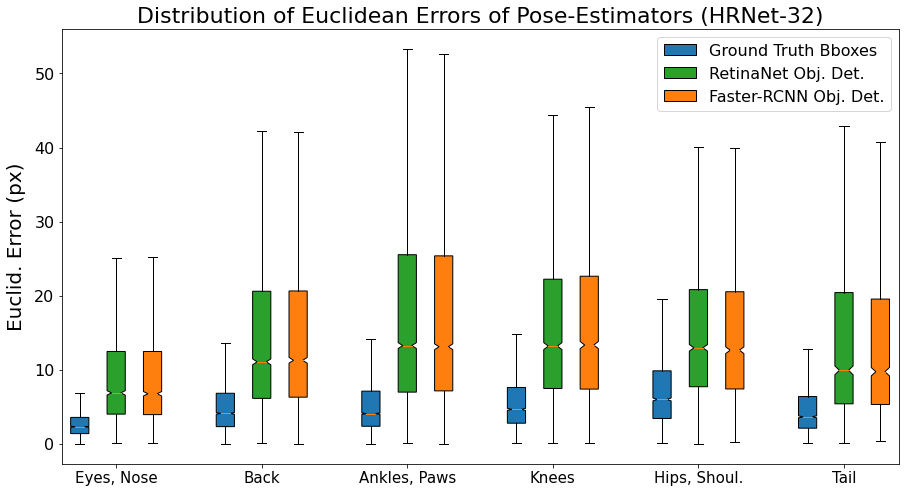

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,8))

bp1 = ax.boxplot(hrnet32_gt, positions=[1, 5, 9,13,17,21], notch=True, widths=0.5, 
                 patch_artist=True, boxprops=dict(facecolor="C0"),showfliers=False)
bp2=ax.boxplot(hrnet32_ret, positions=[2, 6, 10,14,18,22], notch=True, widths=0.5, 
                 patch_artist=True, boxprops=dict(facecolor="C2"),showfliers=False)
bp3 = ax.boxplot(hrnet32_fas, positions=[3, 7, 11,15,19,23], notch=True, widths=0.5, 
                 patch_artist=True, boxprops=dict(facecolor="C1"),showfliers=False)

# ax.set_xticklabels('')#
ax.set_xticks([2,6,10,14,18,22],minor=False)
# ax.set_xticklabels(['Head','Back','Ankles/Paws','Knees','Hip/Shoul','Tail'], minor=True,fontsize=10,visibile=True)
fig.canvas.draw()

# labels = [item.get_text() for item in ax.get_xticklabels()]
labels=['Eyes, Nose','Back','Ankles, Paws','Knees','Hips, Shoul.','Tail']
ax.set_xticklabels(labels,fontsize=15)

plt.yticks(fontsize=16)
plt.ylabel('Euclid. Error (px)',fontsize=20,labelpad=8)
plt.title('Distribution of Euclidean Errors of Pose-Estimators (HRNet-32)',fontsize=22)
# # ax.set_ylabel(labelpad

ax.legend([bp1["boxes"][0], bp2["boxes"][0],bp3["boxes"][0]], ['Ground Truth Bboxes', 'RetinaNet Obj. Det.','Faster-RCNN Obj. Det.'], loc='upper right',fontsize=16)

Text(0.5, 0.98, 'Euclidean Error Distribution Per-Keypoint Per-Model')

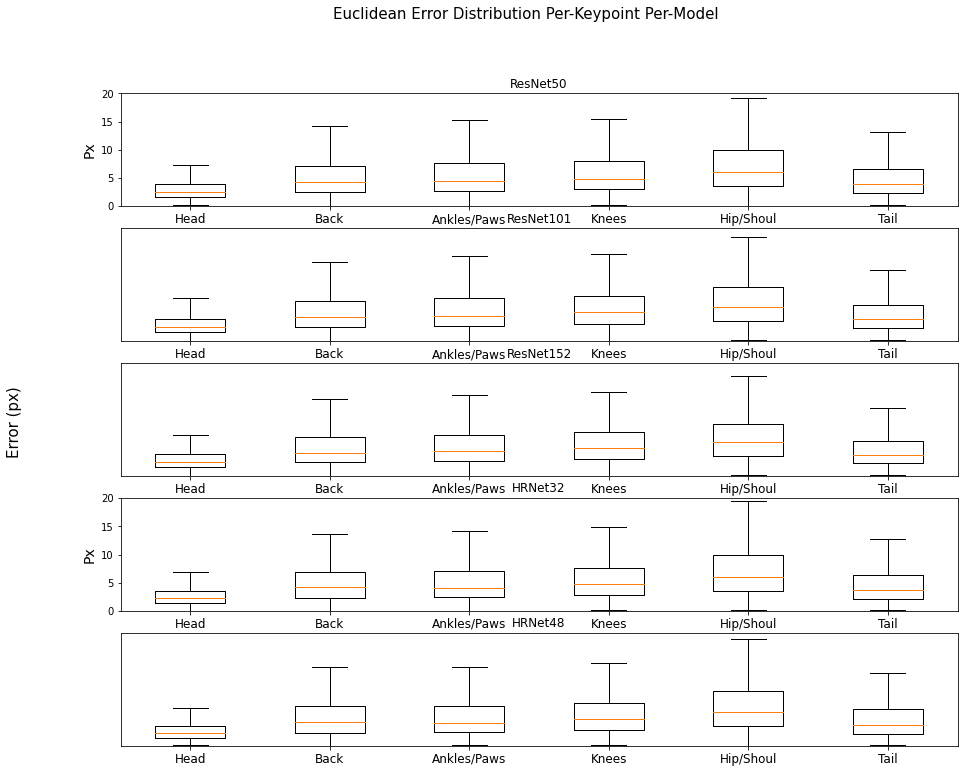

In [160]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(15, 12))
# plt.ylabel("Pixels")
ax1=fig.add_subplot(5,1,1)#([0, 0, 1, 1])
ax2=fig.add_subplot(5,1,2)
ax3=fig.add_subplot(5,1,3)
ax4=fig.add_subplot(5,1,4)
ax5=fig.add_subplot(5,1,5)
bp=ax1.boxplot(resnet50,showfliers=False)
ax1.set_xticklabels(['Head','Back','Ankles/Paws','Knees','Hip/Shoul','Tail'],rotation=0,fontsize=12)
ax1.set_ylim([0, 20])
ax1.set_ylabel('Px',fontsize=14)

bp=ax2.boxplot(resnet101,showfliers=False)
ax2.set_xticklabels(['Head','Back','Ankles/Paws','Knees','Hip/Shoul','Tail'],rotation=0,fontsize=12)
ax2.set_ylim([0, 20])
# ax2.yticks([])
ax2.set_yticks([])

bp=ax3.boxplot(resnet152,showfliers=False)
ax3.set_xticklabels(['Head','Back','Ankles/Paws','Knees','Hip/Shoul','Tail'],rotation=0,fontsize=12)
ax3.set_ylim([0, 20])
ax3.set_yticks([])

bp=ax4.boxplot(hrnet32,showfliers=False)
ax4.set_xticklabels(['Head','Back','Ankles/Paws','Knees','Hip/Shoul','Tail'],rotation=0,fontsize=12)
ax4.set_ylim([0, 20])
# ax4.set_yticks([])
ax4.set_ylabel('Px',fontsize=14)

bp=ax5.boxplot(hrnet48,showfliers=False)
ax5.set_xticklabels(['Head','Back','Ankles/Paws','Knees','Hip/Shoul','Tail'],rotation=0,fontsize=12)#,fontsize=13)
ax5.set_ylim([0, 20])
ax5.set_yticks([])

ax1.title.set_text('ResNet50')
ax2.title.set_text('ResNet101')
ax3.title.set_text('ResNet152')
ax4.title.set_text('HRNet32')
ax5.title.set_text('HRNet48')
# fig.yticks(fontsize=10)
fig.supylabel("Error (px)",fontsize =15)

fig.suptitle("Euclidean Error Distribution Per-Keypoint Per-Model",fontsize =15)
# fig.tight_layout()#w_pad=2,h_pad=2)

# for ax in fig.get_yaxes():
#     ax.label_outer()

In [167]:
for i in range(5):
    print(np.sqrt(np.mean(np.array(hrnet32[i])**2)))

3.7444461473237602
7.72721342248582
9.299355928944896
8.302593864885681
10.131153813942229


In [39]:
per_kp_rmse=np.zeros(24)
for kp in range(len(l2_error)):
    per_kp_rmse[kp]=np.sqrt(np.mean((l2_error[kp])))

per_kp_rmse.mean()  


51.91191942736486

In [23]:
# Eliminating outliers

new_l2_errors=[]
for kp_rmss in l2_error:
    mean=np.mean(kp_rmss)
    std=np.std(kp_rmss)
    error1=[x for x in kp_rmss if (x> mean - 3*std)]
    error1=[x for x in error1 if (x< mean +3*std)]
    new_l2_errors.append(error1)
    # np.sqrt(np.mean(np.array(error1)**2))
# np.std(error1)


In [ ]:
rms=[]
bx_whs=[]
for kp in range(24):
    distr=[]
    n=0
    sum=0
    for delta in deltas:
        if delta[kp][2]<0:
            continue
        distr.append(2-delta[kp][2])
        # if (2-delta[kp][2])<0.5:
        #     continue
        else:
            sum+=delta[kp][0]**2+delta[kp][1]**2
            n+=1
    if n==0:
        rms.append(-1)
    else:
        rms.append(np.sqrt(sum/n))
    bx_whs.append(np.array(distr))



Text(0.5, 1.0, "RetinaNet and Faster-RCNN's IoU scores on AcinoSet test-set")

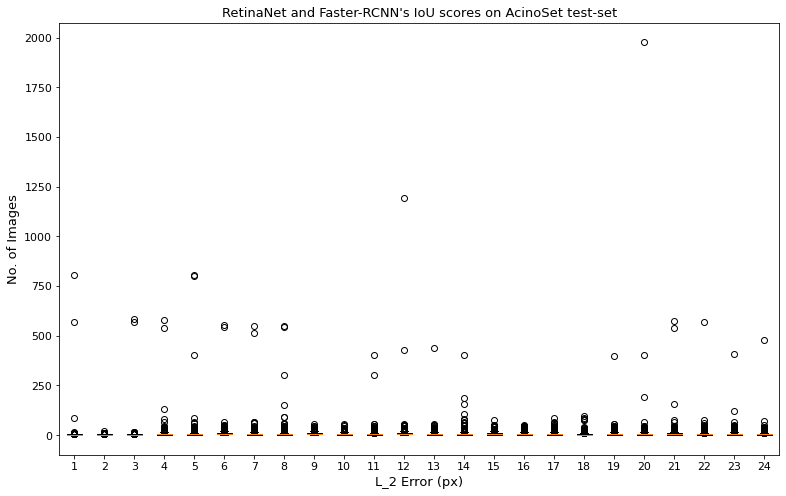

In [134]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(10, 6))
ax=fig.add_axes([0, 0, 1, 1])
bp=ax.boxplot(l2_error,showfliers=True)
ax.tick_params(axis='both', which='major', labelsize=11)
plt.xlabel("L_2 Error (px)",fontsize=13)
plt.ylabel("No. of Images",fontsize =13)
plt.title("RetinaNet and Faster-RCNN's IoU scores on AcinoSet test-set",fontsize=13)

[Text(1, 0, 'L Eye'),
 Text(2, 0, 'R Eye'),
 Text(3, 0, 'Nose'),
 Text(4, 0, 'Neck'),
 Text(5, 0, 'Tail Root'),
 Text(6, 0, 'L Shoulder'),
 Text(7, 0, 'L Elbow'),
 Text(8, 0, 'L Paw'),
 Text(9, 0, 'R Shoulder'),
 Text(10, 0, 'R Elbow'),
 Text(11, 0, 'R Paw'),
 Text(12, 0, 'L Hip'),
 Text(13, 0, 'L Knee'),
 Text(14, 0, 'LB Paw'),
 Text(15, 0, 'R Hip'),
 Text(16, 0, 'R Knee'),
 Text(17, 0, 'RB Paw'),
 Text(18, 0, 'Tail Tip'),
 Text(19, 0, 'Tail Mid'),
 Text(20, 0, 'RF Ankle'),
 Text(21, 0, 'LF Ankle'),
 Text(22, 0, 'RB Ankle'),
 Text(23, 0, 'LB Ankle'),
 Text(24, 0, 'Spine')]

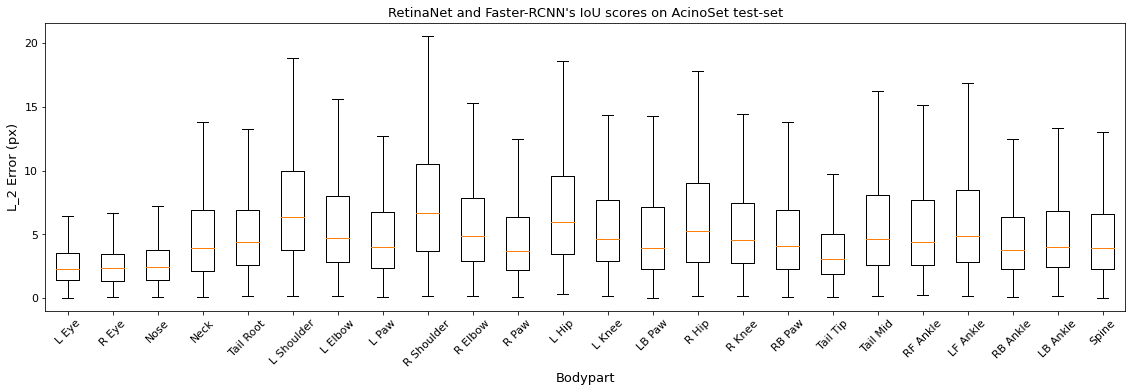

In [145]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(15, 4))
ax=fig.add_axes([0, 0, 1, 1])
bp=ax.boxplot(new,showfliers=False)
ax.tick_params(axis='both', which='major', labelsize=11)
plt.xlabel("Bodypart",fontsize=13)
plt.ylabel("L_2 Error (px)",fontsize =13)
plt.title("RetinaNet and Faster-RCNN's IoU scores on AcinoSet test-set",fontsize=13)
ax.set_xticklabels(axis,rotation=45)

In [151]:
new=[]
for kp in l2_error:
    error1=[x for x in kp if (x>mean-3*5)]
    error1=[x for x in kp if (x<mean+3*5)]
    new.append(error1)
len(np.array(new,dtype=object).flatten())
# axis=['L Eye', 'R Eye', 'Nose', 'Neck', 'Tail Root', 'L Shoulder', 'L Elbow', 'L Paw', 'R Shoulder', 'R Elbow', 'R Paw', 'L Hip', 'L Knee', 'LB Paw', 'R Hip', 'R Knee', 'RB Paw', 'Tail Tip', 'Tail Mid', 'RF Ankle', 'LF Ankle','RB Ankle', 'LB Ankle', 'Spine']

24

In [62]:
test=mmcv.load('data/acino/annotations/acino_test.json')
all=mmcv.load('data/acino/annotations/acino_all.json')
scales=[]
for ann in test['annotations']:
    img_id=ann['id']
    for img in test['images']:
        if img_id==img['id']:
            scale=img['width']*img['height']/ann['area']
            scales.append(scale)
np.mean(scales)

113.72946124210111